# Global birth rate analysis

Birth rate by country and the global birth rate will be analyzed under the impacts of the following factors: 
- Economy: GDP per Capita, inflation
- Social: Happiness index, Social support score, life expectancy, freedom to make life choices, generosity,perception of corruption
- Jobs: Unemployment rate

Please go to the Overall Conclusion section for the result of the analysis. 

In [384]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Import & Data Preparation

In [385]:
# Data import
df_birth_rate = pd.read_csv("birth_rate.csv")
df_gdp = pd.read_csv("GDP.csv")
df_happiness_index = pd.read_excel("DataForFigure2.1WHR2023.xls")
df_unemployment_rate = pd.read_csv('unemployment_rate.csv')
df_inflation_rate = pd.read_excel('inflation-data.xlsx',sheet_name='hcpi_a')


In [386]:
# Drop duplicates & rename columns
df_birth_rate = df_birth_rate.rename({'country': 'Country'}, axis='columns')
df_gdp = df_gdp.drop_duplicates(subset='country', keep='first')
df_gdp = df_gdp.rename({'country': 'Country'}, axis='columns')
df_happiness_index = df_happiness_index.rename({'Country name': 'Country'},
                                               axis='columns')
df_unemployment_rate = df_unemployment_rate.rename({'country': 'Country'},
                                                    axis='columns')
df_inflation_rate = df_inflation_rate.rename({2022:'inflation'}, axis='columns')


In [387]:
# Preliminary variable selection
df_birth_rate = df_birth_rate[['birthRate', 'Country']]
df_gdp = df_gdp[['Country', 'gdpPerCapita']]
df_happiness_index = df_happiness_index[['Country', 'Ladder score', 'Social support', 
                                         'Healthy life expectancy',
                                         'Freedom to make life choices', 
                                         'Generosity', 'Perceptions of corruption']]
df_unemployment_rate = df_unemployment_rate[['Country', 'rateWb']]
df_inflation_rate = df_inflation_rate[['Country', 'inflation']]


In [388]:
# Main data frame preparation
df_final = df_birth_rate.merge(df_gdp,
                                on='Country').merge(df_happiness_index,
                                                     on='Country').merge(df_unemployment_rate, on='Country').merge(df_inflation_rate, on='Country')

df_final.columns

Index(['birthRate', 'Country', 'gdpPerCapita', 'Ladder score',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'rateWb', 'inflation'],
      dtype='object')

In [389]:
df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']] = df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]*100
df_final.loc[8, 'inflation'] = 3.9

In [390]:
# Data partition
df_predictors = df_final[['gdpPerCapita', 'Ladder score','rateWb', 
                            'inflation']]
df_target = df_final['birthRate']

x_train, x_test, y_train, y_test = train_test_split(df_predictors,df_target,test_size=0.25)


## Data Exploration

Noted that due to high multicollinearity between some predictors after checking the VIF scores, the following variables were removed from the model: 
- Social support
- Healthy life expectancy
- Freedom to make life choices
- Generosity
- Perceptions of corruption

In [391]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]

vif_data

,feature,VIF
0,gdpPerCapita,1.956180
1,Ladder score,4.301007
2,rateWb,3.020827
3,inflation,1.216540


In [392]:
# sns.pairplot(df_final)

## Model Fit & Model result

In [393]:
model = linear_model.LinearRegression()

In [394]:
model.fit(x_train,y_train)

LinearRegression()

In [395]:
# birth_rate fitted and birth_rate prediction
y_fitted = model.predict(x_train)
y_predict = model.predict(x_test)

In [396]:
# residuals from train & test
residuals_train = y_train - y_fitted
residuals_test = y_test - y_predict

In [397]:
# Coefficients
coef_gdp = model.coef_[0]
coef_happiness_index = model.coef_[1]
coef_unemployment = model.coef_[2]
coef_inflation = model.coef_[3]
intercept = model.intercept_
model.coef_

array([-1.40936379e-07, -6.87842799e+00, -3.20972545e-01, -4.55982914e-02])

In [398]:
print('model = %f + %f GDP %f Happiness index %f Unemployment %f Inflation' % (intercept, coef_gdp, coef_happiness_index, coef_unemployment, coef_inflation))

model = 60.534897 + -0.000000 GDP -6.878428 Happiness index -0.320973 Unemployment -0.045598 Inflation


In [399]:
stats_model = sm.OLS(y_train, x_train).fit()

## Model & Predictors Evaluation

In [400]:
def model_significance(y_train_set, y_pred, p):
    y_mean = np.mean(y_train_set)
    tss = ((y_train_set - y_mean)**2).sum()
    rss = ((y_train_set - y_pred)**2).sum()
    n = len(y_train_set)
    f_test = (tss-rss)/(rss/(n-p-1))
    print(f_test)
    if f_test > 1:
        print("Reject Ho. At least one of the model coefficients is significant.")
    if f_test <=1: 
        print("Accept Ho. No coefficients are useful.")


def coefficient_testing(coeff, residuals, trainset,p):
    """Perform Hypothesis testing to determine if Coefficient in regression is significant"""
    # Obtain the residual standard deviation
    residual_variance = np.var(residuals)
    x_mean = np.mean(trainset)
    x_squared = ((trainset - x_mean)**2).sum()
    coeff_var = residual_variance/ x_squared
    coeff_std = np.sqrt(coeff_var)
    print("coeff_var, std:",coeff_var, coeff_std)
    # Obtain t test
    print("Hypothesis: Ho: B1 = 0, Ha: B1 !=0")
    t_value = coeff/coeff_std
    print("t_value:", t_value)
    degree_of_freedom = len(trainset) - p -1
    p_value = stats.t.sf(abs(t_value), degree_of_freedom)*2
    print ("p_value: %.24f" % p_value)
    # Conclusion:
    if p_value < 0.05:
        print('Reject Ho. The coefficient is significant, and has a relationship with the respond variable')
    if p_value > 0.05: 
        print('Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable')
    return None


def residual_zero_mean(residuals,p):
    n = len(residuals)
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    t_test = (residual_mean)/(residual_std/np.sqrt(n))
    p_value = stats.t.sf(t_test, n - p - 1)
    if p_value > 0.05:
        print("As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.")
    elif p_value <= 0.05: 
        print("As p_value is smaller than 0.95, there is sufficient evidence to reject Ho. Thus zero mean assumption is not appropriate.")

def tss_rss(y_train, y_pred):
    y_mean = np.mean(y_train)
    tss = ((y_train - y_mean)**2).sum()
    rss = ((y_train - y_pred)**2).sum()
    n = len(y_train)
    return tss, rss

def autocorrelation(residuals):
    print("Ho: There is no correlation among residuals")
    print("Ha: There is correlation between residuals")
    test = durbin_watson(residuals)
    print(test)
    if test>= 0 and test <= 1.5: 
        print("Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.")
    elif test > 1.5 and test <= 2.5:
        print("Do not reject Ho. There is no correlation among residuals.")
    elif test > 2.5:
        print("Reject Ho. There is sufficient evidence indicating a negative correlation in the residuals")
        
def normal_distribution(residuals):
    print("Ho: The residuals are normally distributed.")
    print("Ha: The residuals are not normally distributed.")
    k, p_value = stats.normaltest(residuals)
    print(p_value)
    if p_value < 0.05:
        print("Reject Ho. The residuals are not normally distributed.")
    elif p_value > 0.05:
        print("Do not have sufficient evidence to reject Ho. The residuals are normally distributed.")

### Model Evaluation

In [401]:
# Model evaluation - F test
model_significance(y_train, y_fitted, 4)

99.53502491410006
Reject Ho. At least one of the model coefficients is significant.


### Coefficient evaluation


In [402]:
# GDP coefficient
coefficient_testing(coef_gdp, residuals_train, x_train['gdpPerCapita'],4)

coeff_var, std: 6.761668170922762e-14 2.6003207823118213e-07
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.5419961266759061
p_value: 0.589131521402272206877626
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [403]:
# Happiness index
coefficient_testing(coef_happiness_index, residuals_train, x_train['Ladder score'], 4)

coeff_var, std: 0.43529444000373696 0.6597684745452278
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -10.425517829433755
p_value: 0.000000000000000029249559
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [404]:
# Unemployment rate: rateWb
coefficient_testing(coef_unemployment, residuals_train, x_train['rateWb'], 4)

coeff_var, std: 0.015957298578676973 0.1263222014480312
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.5409036708768076
p_value: 0.012731085570097283241053
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [405]:
# Inflation rate
coefficient_testing(coef_inflation, residuals_train, x_train['inflation'],4)

coeff_var, std: 0.0004601890812429813 0.02145201811585524
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.125594485553607
p_value: 0.036216073825427901045071
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


## Accuracy Evaluation

#### Train set

In [406]:
tss_train, rss_train = tss_rss(y_train, y_fitted)

In [407]:
n_train = len(y_train)
rse_train = np.sqrt(rss_train/(n_train-4-1))
r_squared_train = (tss_train-rss_train)/tss_train

In [408]:
print("RSE:", rse_train)
print("R-squared:", r_squared_train)

RSE: 7.127437741871609
R-squared: 0.5196700966767811


#### Test set

In [409]:
tss_test, rss_test = tss_rss(y_test, y_predict)
n_test = len(y_test)
rse_test = np.sqrt(rss_test/(n_test - 4-1))
r_squared_test = (tss_test-rss_test)/tss_test

In [410]:
print("RSE:", rse_test)
print("R-squared:", r_squared_test)

RSE: 7.469885655935812
R-squared: 0.5206353952525659


## Residuals Evaluation

Residuals will be assessed for the following factors: 
- Mean of zero
- Normally distributed
- Constant variance
- Autocorrelation check

In [411]:
# Test residuals mean of zero
residual_zero_mean(residuals_test, 4)

As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.


Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.399369154159251
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.


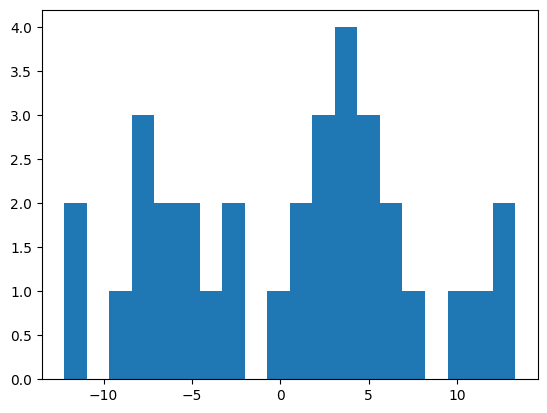

In [412]:
# Test for Normal distribution
plt.hist(residuals_test, bins=20)

normal_distribution(residuals_test)

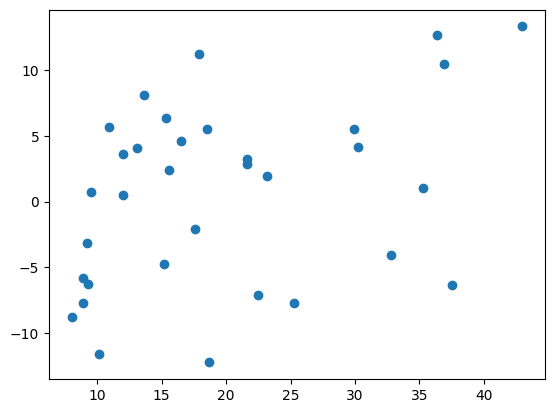

In [413]:
# Test for constant variance
plt.scatter(y_test, residuals_test)

In [414]:
# Autocorrelation check
autocorrelation(residuals_test)



Ho: There is no correlation among residuals
Ha: There is correlation between residuals
1.4327446891835334
Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.


## Model Fit & Evaluation - Interaction terms added

In [415]:
poly = PolynomialFeatures(interaction_only=True)
x_train_interact = poly.fit_transform(x_train)
x_test_interact = poly.fit_transform(x_test)

In [416]:
# Rename columns
df_interact_train = pd.DataFrame(x_train_interact, columns=poly.get_feature_names_out())
df_interact_test = pd.DataFrame(x_test_interact, columns=poly.get_feature_names_out())

In [417]:
selection = SelectKBest(score_func=f_regression, k=4)
results = selection.fit(df_interact_train, y_train)
names = pd.DataFrame(df_interact_train.columns)

print (results.pvalues_)

results_df=pd.DataFrame(results.pvalues_)
results_score = pd.DataFrame(results.scores_)

#Concat and name columns
scored=pd.concat([names,results_df, results_score], axis=1)
scored.columns = ["Feature", "p-values", "scores"]
scored.sort_values(by=['p-values']).head(20)

[1.00000000e+00 3.25582463e-07 1.98797535e-14 2.95417864e-01
 2.74912112e-01 1.54501615e-06 2.84925013e-07 2.97996450e-05
 6.81980798e-03 6.22516365e-01 3.09388928e-01]


,Feature,p-values,scores
2,Ladder score,1.987975e-14,81.480902
6,gdpPerCapita rateWb,2.849250e-07,30.545359
1,gdpPerCapita,3.255825e-07,30.203696
5,gdpPerCapita Ladder score,1.545016e-06,26.291626
7,gdpPerCapita inflation,2.979964e-05,19.240934
8,Ladder score rateWb,6.819808e-03,7.650665
4,inflation,2.749121e-01,1.205945
3,rateWb,2.954179e-01,1.106936
10,rateWb inflation,3.093889e-01,1.044430
9,Ladder score inflation,6.225164e-01,0.243938


Variable selected: Aiming at 15 observations per variable:'Ladder score', 'gdpPerCapita', 'gdpPerCapita rateWb', 'gdpPerCapita Ladder score', 'rateWb'


In [418]:
scored_sorted = scored.sort_values(by=['p-values'])
print(scored_sorted['Feature'])
columns = list(['Ladder score', 'gdpPerCapita', 'gdpPerCapita rateWb', 'gdpPerCapita Ladder score', 'rateWb'])

2                  Ladder score
6           gdpPerCapita rateWb
1                  gdpPerCapita
5     gdpPerCapita Ladder score
7        gdpPerCapita inflation
8           Ladder score rateWb
4                     inflation
3                        rateWb
10             rateWb inflation
9        Ladder score inflation
0                             1
Name: Feature, dtype: object


In [419]:
df_interact_train = df_interact_train[columns]
df_interact_test = df_interact_test[columns]

In [420]:
df_interact_train.head(5)

,Ladder score,gdpPerCapita,gdpPerCapita rateWb,gdpPerCapita Ladder score,rateWb
0,3.9822,1.347076e+05,1.683845e+06,5.364326e+05,12.5
1,6.8937,7.851594e+06,6.359791e+07,5.412654e+07,8.1
2,5.6304,7.112773e+05,1.066916e+07,4.004776e+06,15.0
3,6.5891,1.571894e+06,7.859472e+06,1.035737e+07,5.0
4,5.6325,7.777076e+05,1.236555e+07,4.380438e+06,15.9


In [421]:
model_int = linear_model.LinearRegression()
model_int.fit(df_interact_train, y_train)

LinearRegression()

In [422]:
# y fitted and y predict
y_fitted_int = model_int.predict(df_interact_train)
y_predict_int = model_int.predict(df_interact_test)

In [423]:
# Residuals train and test
residuals_interact_train = y_train - y_fitted_int
residuals_interact_test = y_test - y_predict_int

In [424]:
# coefficient
df_interact_train.columns
coef_int_happiness = model_int.coef_[0]
coef_int_gdp = model_int.coef_[1]
coef_int_gdp_unempl = model_int.coef_[2]
coef_int_gdp_happiness = model_int.coef_[3]
coef_int_unemploy = model_int.coef_[4]
model_int.coef_

array([-6.84575486e+00, -1.76406132e-05,  2.79248318e-08,  2.44572582e-06,
       -2.97849306e-01])

In [425]:
print("interaction_model = %f  %f happiness_index %f gdpPerCapita + %f unemployment + %f  gdp*happiness_index %f Unemployment_rate" % (model_int.intercept_, coef_int_happiness, coef_int_gdp, coef_int_gdp_unempl, coef_int_gdp_happiness, coef_int_unemploy))

interaction_model = 62.020719  -6.845755 happiness_index -0.000018 gdpPerCapita + 0.000000 unemployment + 0.000002  gdp*happiness_index -0.297849 Unemployment_rate


### Model & coefficient evaluation

In [426]:
# F_test
model_significance(y_train, y_fitted_int, 5)

158.43703237439644
Reject Ho. At least one of the model coefficients is significant.


In [427]:
coefficient_testing(coef_int_happiness, residuals_interact_train, df_interact_train['Ladder score'],5)

coeff_var, std: 0.3306160679801843 0.5749922329737892
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -11.90582145484222
p_value: 0.000000000000000000029443
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [428]:
coefficient_testing(coef_int_gdp, residuals_interact_train, df_interact_train['gdpPerCapita'],5)

coeff_var, std: 5.135641391693531e-14 2.2661953560303514e-07
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -77.84242056653986
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [429]:
coefficient_testing(coef_int_gdp_unempl, residuals_interact_train, df_interact_train['gdpPerCapita rateWb'],5)

coeff_var, std: 1.2319372878876994e-15 3.509896419964127e-08
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.7956027325472029
p_value: 0.428333410766921218737480
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [430]:
coefficient_testing(coef_int_gdp_happiness, residuals_interact_train, df_interact_train['gdpPerCapita Ladder score'],5)

coeff_var, std: 1.0080839937345074e-15 3.175033848220374e-08
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 77.02991326752556
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [431]:
coefficient_testing(coef_int_unemploy, residuals_interact_train, df_interact_train['rateWb'],5)

coeff_var, std: 0.012119932686534364 0.11009056583801521
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.705493461504072
p_value: 0.008142435895198913212156
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [432]:
tss_int, rss_int = tss_rss(y_train, y_fitted_int)
n_int = len(y_train)

In [433]:
rse_int = np.sqrt(rss_int/(n_int - 5 -1))
r_squared_int = (tss_int - rss_int)/tss_int
print(rse_int, r_squared_int)

6.245641731936873 0.6351784691560468


In [434]:
tss_int_test, rss_int_test = tss_rss(y_test, y_predict_int)
n_int_test = len(y_test)
rse_int_test = np.sqrt(rss_int_test/(n_int_test - 5-1))
r_squared_int_test = (tss_int_test - rss_int_test)/tss_int_test
print(rse_int_test, r_squared_int_test)

6.592513024078231 0.6399641216660965


### Residuals evaluation

Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.5713697294631175
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.
Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.9524076237691032
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.


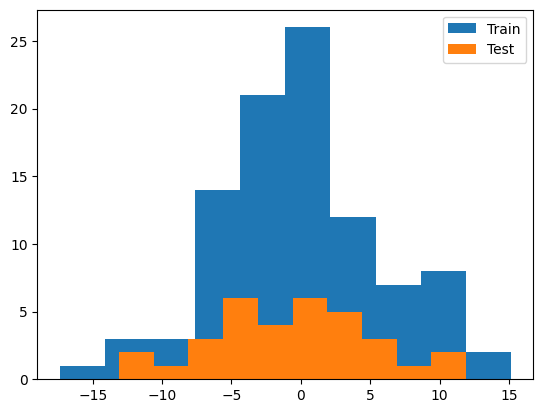

In [435]:
# Histogram
plt.hist(residuals_interact_train)
plt.hist(residuals_interact_test)
plt.legend(['Train', 'Test'])
normal_distribution(residuals_interact_train)
normal_distribution(residuals_interact_test)

In [436]:
# Zero mean
residual_zero_mean(residuals_interact_train,5)
residual_zero_mean(residuals_interact_test,5)

As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.
As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.


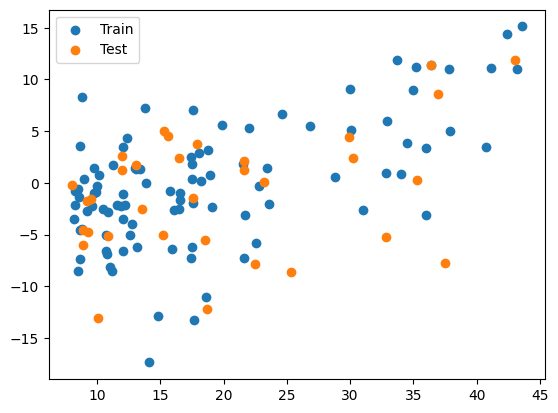

In [437]:
# Constant variance
plt.scatter(y_train,residuals_interact_train)
plt.scatter(y_test, residuals_interact_test)
plt.legend(['Train', 'Test'])


In [438]:
# Autocorrelation
autocorrelation(residuals_interact_train)
autocorrelation(residuals_interact_test)

Ho: There is no correlation among residuals
Ha: There is correlation between residuals
2.185752798964202
Do not reject Ho. There is no correlation among residuals.
Ho: There is no correlation among residuals
Ha: There is correlation between residuals
1.3696468753351843
Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.


# Overall Conclusion

With multiple linear regression without interaction terms, the following predictors have significant impacts on the response variable (birth rate): 
- Happiness index
- Unemployment
- Inflation

Noted that the increase in social support and healthy life expectancy increase the birth rates. The 4 predictors in the model were able to explain 52.06% of the model variations in the test set. 

Through the incorporation of the interaction terms and variable selection, the following variables show significant impacts on the response variable (birth rate): 
- Happiness index
- GDP
- Unemployment rate
- Interaction term between GDP and happiness index

Noted that the r_squared score, which represents how well these predictors were able to explain the model variations, increases to  64.00% in the test set with interaction term in comparison to 52.06%. In addition, the interaction term model showed a decrease in the RSE (residuals squared errors), represented the errors not explained by the model, to RSE 6.59 in the test set from RSE 7.47 in the test set from the original model. 

Noted that happiness index also includes measurements of the following: Freedom to make life choices, social support, healthy life expectancy, perceptions of corruptions, and generosity. Due to high collinearity between this predictors, only happiness index was included in the model. 

Based on the results. An interesting insight is that the coefficient for happiness index in both models is negative, indicating high happiness index negatively affect the birth rate. Taken into account the high correlation between happiness index and freedom to make life choices, and other social aspects, there is a possibility that high level of social support and freedom to make life choices criteria from the specific country encourages individuals to live the life that they prefer, with or without children, thus affecting the birth rates. However, unemployment rate and inflation rates are also predictors that negatively affect the birth rates in the models. 

Noted that for both model (without interaction terms and with interaction terms), the error terms conform with the following criteria: 
- Normally distributed
- Constant variance
- Shows no autocorrelation
- Shows means of zero
